##### Markov Model Captures "Flow," Not "Meaning"

The Markov model calculates the probability of which word is likely to follow another  
($P(w_t \mid w_{t-1})$). An author's signature is not only the words they use, but how they  
structure them.

- **Poe**: "The bird hath flown" (archaic English usage)  
- **Frost**: "The bird has flown" (modern usage)

If you apply lemmatization:  
- *hath* → *have*  
- *has* → *have*  
- *flown* → *fly*  

Both sentences collapse into: **"the bird have fly"**.  
This destroys the author's unique grammatical style (their *voice*), making it harder for the model  
to distinguish between Poe and Frost.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
import re

In [34]:
def get_data(TXT_DIR):
    line_list = []
    TXT_DIR = "../"+TXT_DIR
    with open(TXT_DIR, 'r', encoding='utf-8') as file:
        for line in file:
            #normalization
            line = line.strip()
            line = line.lower()
            line = re.sub(r'[^\w\s]', '', line) #substitute (replace)
            line = re.sub(r'\d', '', line)
            if line != "":
                tokens = line.split()
                line_list.append(tokens) #Markov models want this format. 
    return line_list 

In [35]:
poe_list = get_data('data/edgar_allan_poe.txt')
frost_list = get_data('data/robert_frost.txt')

In [36]:
print(len(poe_list))
print(len(frost_list))


718
1436


In [37]:
# for poe = 0 and frost = 1 mapping
inputs = poe_list + frost_list
labels = [0]*len(poe_list) + [1]*len(frost_list)

print(len(inputs))
print(len(labels))

2154
2154


In [38]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, shuffle=True, train_size=0.80, test_size=0.20, random_state=42)

print(len(X_train), "-", len(y_train))
print(len(X_test), "-", len(y_test))
print(X_train[100], "-", y_train[100])

1723 - 1723
431 - 431
['not', 'lupine', 'living', 'on', 'sand', 'and', 'drouth'] - 1


* in markov models we need to map unique words into integers, so it can procude it.
* since in real world we can have unknown words, we should only use X_train

In [39]:
#Old code:

#all_x_train = ""
#for sentence in X_train:
#    all_x_train += ' '.join(sentence) + ' '
#unique_words = list(set(all_x_train.split()))
#unique_words.insert(0, '<UNKNOWN>')
##create a unique word dict
#word2idx = {word: i for i, word in enumerate(unique_words)}
#
#print(len(word2idx))

In [40]:
#Since strings in python are immutable, editing is slow
#Faster way:

#create empty set
word_set = set()
#directly add words into set
for sentence in X_train:
    word_set.update(sentence)
idx2word = list(word_set)
idx2word.insert(0, '<UNKNOWN>')

word2idx = {word:i for i, word in enumerate(idx2word)}
print(len(word2idx))
print(list(word2idx.items())[0:5])

2604
[('<UNKNOWN>', 0), ('merrily', 1), ('wings', 2), ('reason', 3), ('bulkhead', 4)]


In [41]:
print(X_train[0])
print([word2idx[word] for word in X_train[0]])

['and', 'many', 'must', 'have', 'seen', 'him', 'make']
[820, 641, 353, 171, 781, 2176, 840]


In [42]:
##turn inputs into numbers
#
#test_idx = []
#for sentence in test_list:
#    sample = []
#    for word in sentence:
#        try:            
#            sample.append(word2idx[word])
#        except:
#            sample.append(0)
#    test_idx.append(sample)
#test_idx

In [43]:
def word_numerizer(arr):
    int_list = []
    for sentence in arr:
        sample = [word2idx.get(word, 0) for word in sentence]
        int_list.append(sample)
    return int_list

In [44]:
X_train_int = word_numerizer(X_train)
X_test_int  = word_numerizer(X_test)

In [45]:
print(X_test[10])
print(X_test_int[10])

['in', 'joy', 'and', 'wo', 'in', 'good', 'and', 'ill']
[2528, 2006, 820, 0, 2528, 174, 820, 983]


In [46]:
    # dict&list are muttable, regular variables like integer is immutable.
    #x = 50
    #x_ = x
    #x_ += 30
    # this does not affect value of x
    #
    #my_dict = {}
    #another_dict = my_dict  # Referance (Pointer)
    #another_dict["test"] = 999
    #this affects values of my_dict

In [47]:
# Prepare A and pi

A_poe, A_frost = {}, {}
pi_poe, pi_frost = {}, {}

for sentence, labels in zip(X_train_int, y_train):
    if labels == 0:
        current_A = A_poe
        current_pi = pi_poe
    else:
        current_A = A_frost
        current_pi = pi_frost
    
    #pi
    if sentence[0] not in current_pi:
        current_pi[sentence[0]] = 1
    else:
        current_pi[sentence[0]] +=1
    #A
    for word_index in range(len(sentence)-1):
        #key
        current_word = sentence[word_index]
        next_word    = sentence[word_index+1]

        if current_word not in current_A:
            current_A[current_word] = {}
            current_A[current_word][next_word] = 1                    
        else:
            if next_word not in current_A[current_word]:
                current_A[current_word][next_word]= 1
            else:
                current_A[current_word][next_word]+= 1

In [48]:
# Matrices as probabilities

# FOR pi

def calc_unigram_probabilities(dict_):
    M = len(word2idx)
    total_count = 0
    for val in dict_.values():
        total_count += val

    for key, value in dict_.items():
        dict_[key] = np.log((value + 1)/(total_count + M))

# FOR A
def calc_bigram_probabilities(dict_):
    for key in dict_.keys():
        calc_unigram_probabilities(dict_[key])

In [49]:
# Matrices as probabilities

# FOR pi

def calc_pi_probs(dict_):
    #smoothing formula: (value + 1) / (total_count + V)
    new_pi = {}
    M = len(word2idx)
    total_count = 0
    for val in dict_.values():
        total_count += val

    for key, value in dict_.items():
        new_pi[key] = np.log((value + 1)/(total_count + M))

    default_prob = np.log((1)/(total_count + M))
    return new_pi, default_prob

# FOR A
def calc_A_probsprobabilities(dict_):
    new_A = {}
    
    for key in dict_.keys():
        new_pi, default_prob = calc_pi_probs(dict_[key])
        new_A[key] = new_pi
        new_A[key]['<DEFAULT>'] = default_prob
    
    return new_A

In [50]:
log_pi_poe, default_pi_poe = calc_pi_probs(pi_poe)
log_pi_frost, default_pi_frost =calc_pi_probs(pi_frost)
log_pi_poe['<DEFAULT>'] = default_pi_poe
log_pi_frost['<DEFAULT>'] = default_pi_frost

log_A_poe = calc_A_probsprobabilities(A_poe)
log_A_frost = calc_A_probsprobabilities(A_frost)

In [51]:
# Decision Rule is k* = argmax log(p(x|class=k))
print(X_test[0], y_test[0])
print(X_test_int[0])

score = 0
if len(X_test_int[0]) != 0:
    first_word = X_test_int[0][0]
    if first_word in log_pi_poe:
        score += log_pi_poe[first_word]
    else:
        score += log_pi_poe['<DEFAULT>']

for i in range(len(X_test_int[0])-1):
    current_word = X_test_int[0][i]
    next_word = X_test_int[0][i+1]
    if current_word in log_A_poe:
        if next_word in log_A_poe[current_word]:
            score+= log_A_poe[current_word][next_word]
        else:
            score+= log_A_poe[current_word]['<DEFAULT>']
    else:
        # if the current word does not appear in the A, we add penalty to score.
        # usually default of pi is used for this penalty
        score += log_pi_poe['<DEFAULT>']
    
score

['beyond', 'where', 'they', 'were', 'was', 'a', 'shattered', 'seedpod'] 1
[194, 1327, 2076, 1405, 1015, 92, 0, 0]


np.float64(-59.90187119032256)

In [52]:
def compute_score(input_sentence, log_pi, log_A):
    score = 0
    if len(input_sentence) != 0:
        first_word = input_sentence[0]
        if first_word in log_pi:
            score += log_pi[first_word]
        else:
            score += log_pi['<DEFAULT>']

    for i in range(len(input_sentence)-1):
        current_word = input_sentence[i]
        next_word = input_sentence[i+1]
        if current_word in log_A:
            if next_word in log_A[current_word]:
                score+= log_A[current_word][next_word]
            else:
                score+= log_A[current_word]['<DEFAULT>']
        else:
            # if the current word does not appear in the A, we add penalty to score.
            # usually default of pi is used for this penalty
            score += log_pi['<DEFAULT>']
    return score

In [53]:
def predict_by_markov_with_print(sentence_idx): # for one sentence
    #poe = 0 and frost = 1
    if y_test[sentence_idx] == 0:
        true_label = "Poe"
    else:
        true_label = "Frost"

    print(X_test[sentence_idx], "-", true_label)
    
    score_poe = compute_score(input_sentence=X_test_int[sentence_idx], log_pi=log_pi_poe, log_A=log_A_poe)
    score_frost = compute_score(input_sentence=X_test_int[sentence_idx], log_pi=log_pi_frost, log_A=log_A_frost)
    print("Score for Poe:",score_poe," | ", "Score for Frost:", score_frost)
    if np.argmax([score_poe, score_frost]) == 0:
        predict_label = "Poe"
    else:
        predict_label = "Frost"
    
    print("True Label:", true_label, " | ", "Predicted Label:", predict_label)

In [54]:
predict_by_markov_with_print(sentence_idx=0)

['beyond', 'where', 'they', 'were', 'was', 'a', 'shattered', 'seedpod'] - Frost
Score for Poe: -59.90187119032256  |  Score for Frost: -58.02628155143897
True Label: Frost  |  Predicted Label: Frost


In [55]:
def predict_all(sentence_idx):
    #poe = 0 and frost = 1
    score_poe = compute_score(input_sentence=X_test_int[sentence_idx], log_pi=log_pi_poe, log_A=log_A_poe)
    score_frost = compute_score(input_sentence=X_test_int[sentence_idx], log_pi=log_pi_frost, log_A=log_A_frost)
    predict_label = int(np.argmax([score_poe, score_frost]))
    
    return predict_label

In [56]:
y_pred = []

for i in range(len(X_test_int)):
    y_pred.append(predict_all(i))

In [57]:
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nF1 Score: {f1_score(y_test, y_pred):.4f}")

[[122  26]
 [ 34 249]]

F1 Score: 0.8925


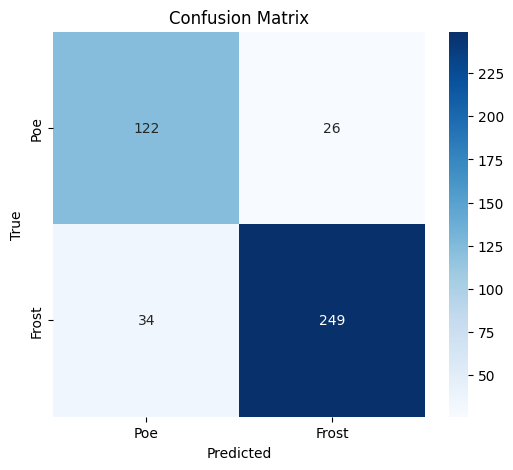

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Poe', 'Frost'], yticklabels=['Poe', 'Frost'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()